# Deep Crossing
## 动机
2016年由微软提出，将深度学习应用于推荐系统中的模型，完整的解决来特征工程与稀疏向量稠密化。  

DeepCrossing模型应用场景是微软搜索引擎Bing中的搜索广告推荐， 用户在输入搜索词之后， 搜索引擎除了返回相关结果， 还返回与搜索词相关的广告，Deep Crossing的优化目标就是预测对于某一广告， 用户是否会点击，依然是点击率预测的一个问题。  

## 模型结构与原理
为了完成端到端的训练， DeepCrossing模型要在内部网络结构中解决如下问题：  
1. 离散类特征编码后过于稀疏， 不利于直接输入神经网络训练， 需要解决稀疏特征向量稠密化的问题
2. 如何解决特征自动交叉组合的问题
3. 如何在输出层中达成问题设定的优化目标
Deep Crossing分别设置了不同神经网络层解决上述问题。模型结构如下  
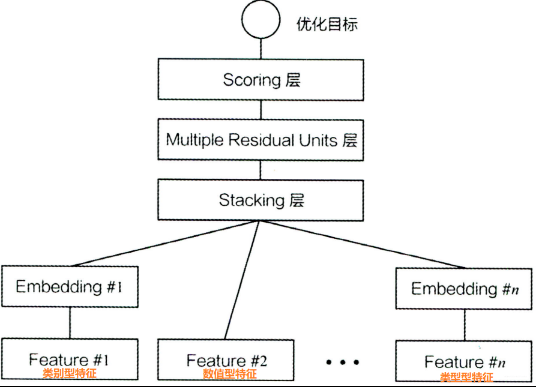

### Embedding Layer
将稀疏的类别型特征转成稠密的Embedding向量，Embedding的维度会远小于原始的稀疏特征向量。  
这里的Feature #1表示的类别特征(one-hot编码后的稀疏特征向量）， Feature #2是数值型特征，不用embedding， 直接到了Stacking Layer。  
  
  
### Stacking Layer
这个层是**把不同的Embedding特征和数值型特征拼接在一起，形成新的包含全部特征的特征向量**，该层通常也称为连接层, 具体的实现如下，先将所有的数值特征拼接起来，然后将所有的Embedding拼接起来，最后将数值特征和Embedding特征拼接起来作为DNN的输入，这里TF是通过Concatnate层进行拼接。

In [ ]:
#将所有的dense特征拼接到一起
dense_dnn_list = list(dense_input_dict.values())
dense_dnn_inputs = Concatenate(axis=1)(dense_dnn_list) # B x n (n表示数值特征的数量)

# 因为需要将其与dense特征拼接到一起所以需要Flatten，不进行Flatten的Embedding层输出的维度为：Bx1xdim
sparse_dnn_list = concat_embedding_list(dnn_feature_columns, sparse_input_dict, embedding_layer_dict, flatten=True) 

sparse_dnn_inputs = Concatenate(axis=1)(sparse_dnn_list) # B x m*dim (n表示类别特征的数量，dim表示embedding的维度)

# 将dense特征和Sparse特征拼接到一起
dnn_inputs = Concatenate(axis=1)([dense_dnn_inputs, sparse_dnn_inputs]) # B x (n + m*dim)

### Multiple Residual Units Layers
该层的主要结构是MLP， 但DeepCrossing采用了残差网络进行的连接。通过多层残差网络对特征向量各个维度充分的交叉组合， 使得模型能够抓取更多的非线性特征和组合特征信息， 增加模型的表达能力。残差网络结构如下图所示：
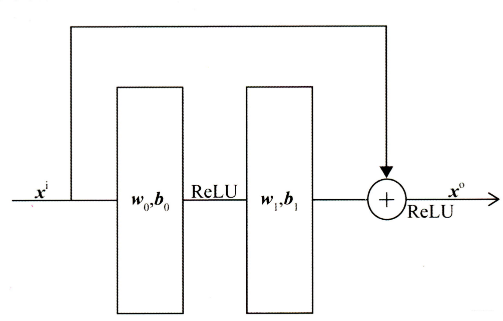
Deep Crossing模型使用稍微修改过的残差单元，它不使用卷积内核，改为了两层神经网络。我们可以看到，残差单元是通过两层ReLU变换再将原输入特征相加回来实现的。具体代码实现如下：


In [ ]:
# DNN残差块的定义
class ResidualBlock(Layer):
    def __init__(self, units): # units表示的是DNN隐藏层神经元数量
        super(ResidualBlock, self).__init__()
        self.units = units

    def build(self, input_shape):
        out_dim = input_shape[-1]
        self.dnn1 = Dense(self.units, activation='relu')
        self.dnn2 = Dense(out_dim, activation='relu') # 保证输入的维度和输出的维度一致才能进行残差连接
    def call(self, inputs):
        x = inputs
        x = self.dnn1(x)
        x = self.dnn2(x)
        x = Activation('relu')(x + inputs) # 残差操作
        return x

### Scoring Layer
这个作为输出层，为了拟合优化目标存在。 对于CTR预估二分类问题， Scoring往往采用逻辑回归，模型通过叠加多个残差块加深网络的深度，最后将结果转换成一个概率值输出。

In [ ]:
# block_nums表示DNN残差块的数量
def get_dnn_logits(dnn_inputs, block_nums=3):
    dnn_out = dnn_inputs
    for i in range(block_nums):
        dnn_out = ResidualBlock(64)(dnn_out)
    
    # 将dnn的输出转化成logits
    dnn_logits = Dense(1, activation='sigmoid')(dnn_out)

    return dnn_logits

## 总结
DeepCrossing模型中没有任何人工特征工程的参与，只需要简单的特征处理，原始特征经Embedding Layer输入神经网络层，自主交叉和学习。 相比于FM，FFM只具备二阶特征交叉能力的模型，DeepCrossing可以通过调整神经网络的深度进行特征之间的“深度交叉”，这也是Deep Crossing名称的由来。  
如果是用于点击率预估模型的损失函数就是对数损失函数：

$$ logloss=-\frac 1N\sum_1^N(y_ilog(p_i)+(1-y_i)log(1-p_i) $$ 其中$$y_i$$表示真实的标签（点击或未点击），$$p_i$$表示Scoring Layer输出的结果。但是在实际应用中，根据不同的需求可以灵活替换为其他目标函数。

## 代码实现
从模型的代码结构上来看，DeepCrossing的模型输入主要由数值特征和类别特征组成，并将经过Embedding之后的类别特征及类别特征拼接在一起，详细的拼接代码如Staking Layer所示，下面是构建模型的核心代码。

In [ ]:
def DeepCrossing(dnn_feature_columns):
    # 构建输入层，即所有特征对应的Input()层，这里使用字典的形式返回，方便后续构建模型
    dense_input_dict, sparse_input_dict = build_input_layers(dnn_feature_columns)

    # 构建模型的输入层，模型的输入层不能是字典的形式，应该将字典的形式转换成列表的形式
    # 注意：这里实际的输入与Input()层的对应，是通过模型输入时候的字典数据的key与对应name的Input层
    input_layers = list(dense_input_dict.values()) + list(sparse_input_dict.values())
    
    # 构建维度为k的embedding层，这里使用字典的形式返回，方便后面搭建模型
    embedding_layer_dict = build_embedding_layers(dnn_feature_columns, sparse_input_dict, is_linear=False)

    #将所有的dense特征拼接到一起
    dense_dnn_list = list(dense_input_dict.values())
    dense_dnn_inputs = Concatenate(axis=1)(dense_dnn_list) # B x n (n表示数值特征的数量)

    # 因为需要将其与dense特征拼接到一起所以需要Flatten，不进行Flatten的Embedding层输出的维度为：Bx1xdim
    sparse_dnn_list = concat_embedding_list(dnn_feature_columns, sparse_input_dict, embedding_layer_dict, flatten=True) 

    sparse_dnn_inputs = Concatenate(axis=1)(sparse_dnn_list) # B x m*dim (n表示类别特征的数量，dim表示embedding的维度)

    # 将dense特征和Sparse特征拼接到一起
    dnn_inputs = Concatenate(axis=1)([dense_dnn_inputs, sparse_dnn_inputs]) # B x (n + m*dim)

    # 输入到dnn中，需要提前定义需要几个残差块
    output_layer = get_dnn_logits(dnn_inputs, block_nums=3)

    model = Model(input_layers, output_layer)
    return model

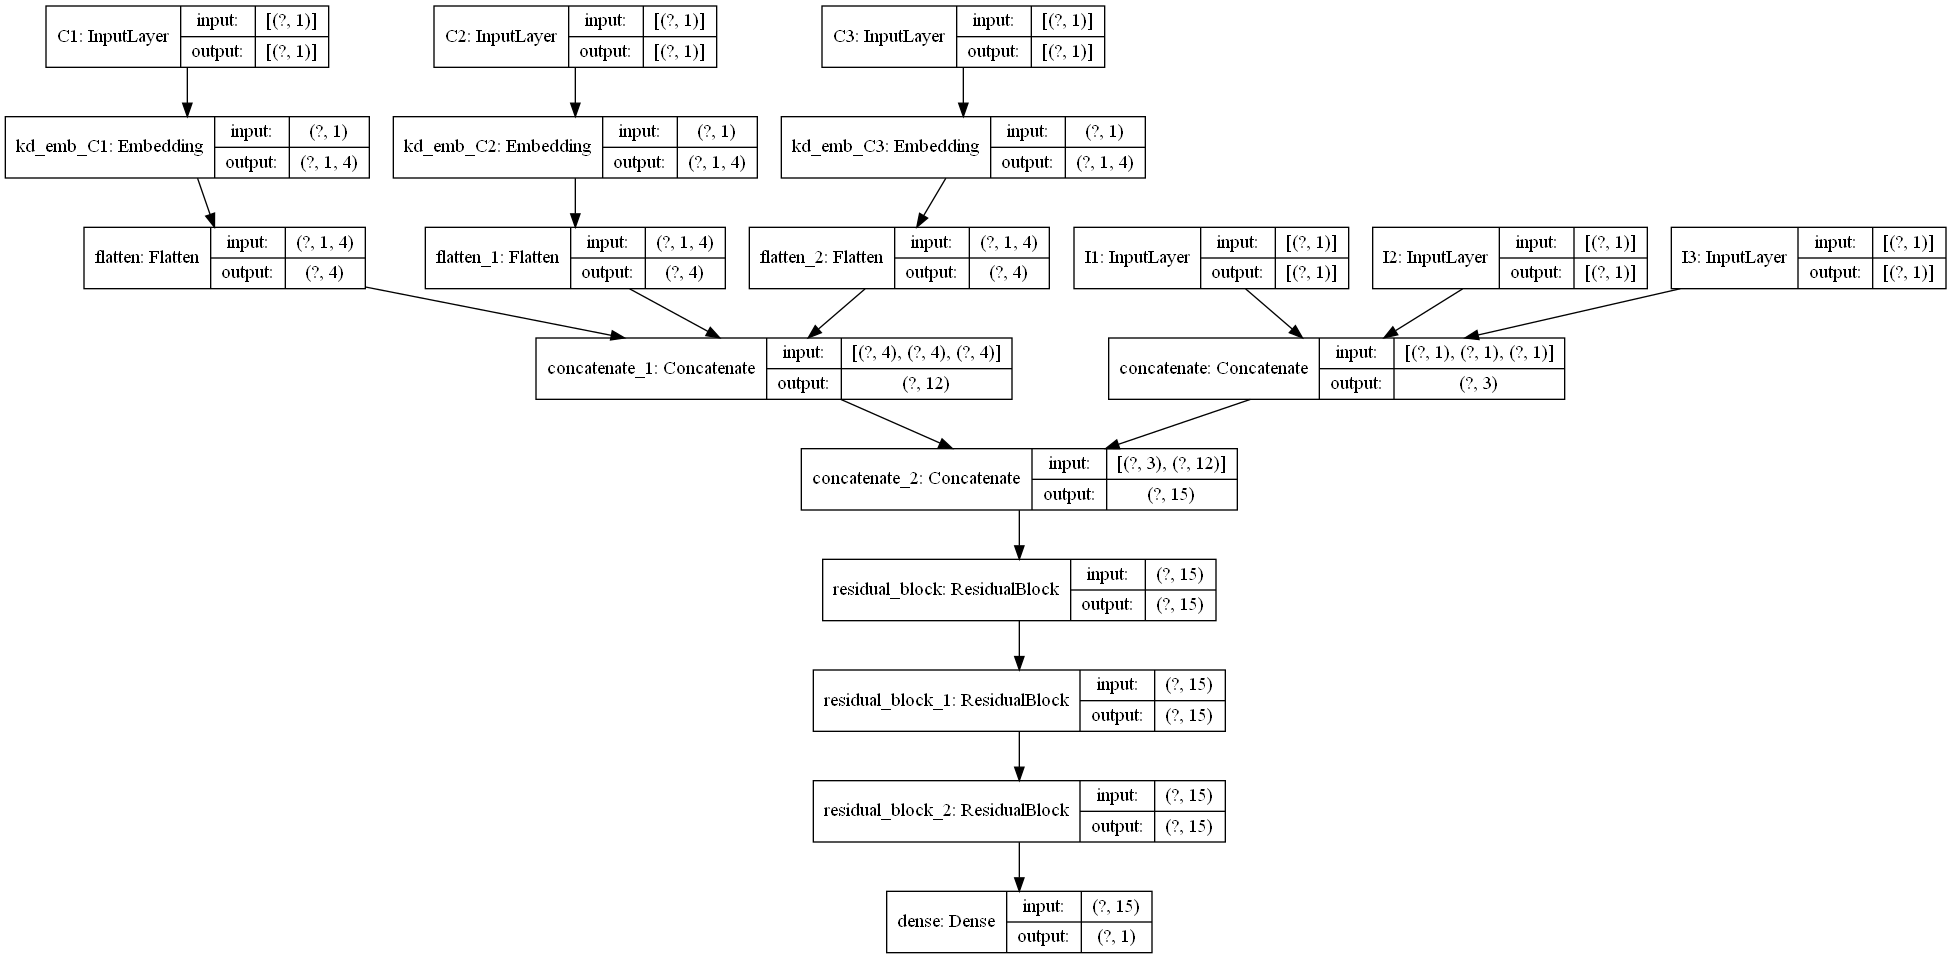  
  
---

In [1]:
import warnings
warnings.filterwarnings("ignore")
import itertools
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import namedtuple

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  MinMaxScaler, LabelEncoder

from utils import SparseFeat, DenseFeat, VarLenSparseFeat


In [2]:
def data_process(data_df, dense_features, sparse_features):
    """
    简单处理特征，包括填充缺失值、数值处理、类别编码
    
    param data_df: DataFrame格式的数据
    param dense_features: 数值特征名称列表
    param sparse_features: 类别特征名称列表
    """
    data_df[dense_features] = data_df[dense_features].fillna(0.0)  # 将dense_features的缺失值以0.0填充
    for f in dense_features:
        data_df[f] = data_df[f].apply(lambda x: np.log(x+1) if x > -1 else -1)  # 对连续属性的数值取log
        
    data_df[sparse_features] = data_df[sparse_features].fillna("-1")  # 将sparse_features的缺失值以-1填充
    for f in sparse_features:
        lbe = LabelEncoder()  # LabelEncoder可以将标签分配一个0～n_classes-1之间的编码
        data_df[f] = lbe.fit_transform(data_df[f])
    
    return data_df[dense_features + sparse_features]

### 数据取对数对意义
因对数函数在其定义域内是单调增函数，取对数后不会改变数据的关系。**需注意负数与0不得取对数。**
1. 缩小数据的绝对数值，方便计算，类似归一化。
2. 取对数后可以将乘法计算转换为加法计算。
3. 取对数之后不会改变数据的性质和相关关系，但压缩了变量的尺度，使得数据更加平稳，也消弱了模型的共线性、异方差性等。

In [3]:
def build_input_layers(feature_columns):
    """
    构建输入层
    param feature_columns: 数据集中的所有特征对应的特征标记之
    """
    # 构建Input层字典，并以dense和sparse两类字典的形式返回
    dense_input_dict, sparse_input_dict = {}, {}

    for fc in feature_columns:
        if isinstance(fc, SparseFeat):
            sparse_input_dict[fc.name] = Input(shape=(1, ), name=fc.name)
        elif isinstance(fc, DenseFeat):
            dense_input_dict[fc.name] = Input(shape=(fc.dimension, ), name=fc.name)
        
    return dense_input_dict, sparse_input_dict

In [4]:
def build_embedding_layers(feature_columns, input_layers_dict, is_linear):
    # 定义一个embedding层对应的字典
    embedding_layers_dict = dict()
    
    # 将特征中的sparse特征筛选出来
    sparse_feature_columns = list(filter(lambda x: isinstance(x, SparseFeat), feature_columns)) if feature_columns else []
    
    # 如果是用于线性部分的embedding层，其维度为1，否则维度就是自己定义的embedding维度
    if is_linear:
        for fc in sparse_feature_columns:
            embedding_layers_dict[fc.name] = Embedding(fc.vocabulary_size + 1, 1, name='1d_emb_' + fc.name)
    else:
        for fc in sparse_feature_columns:
            embedding_layers_dict[fc.name] = Embedding(fc.vocabulary_size + 1, fc.embedding_dim, name='kd_emb_' + fc.name)
    
    return embedding_layers_dict


In [5]:
# 将所有的sparse特征embedding拼接
def concat_embedding_list(feature_columns, input_layer_dict, embedding_layer_dict, flatten=False):
    # 将sparse特征筛选出来
    sparse_feature_columns = list(filter(lambda x: isinstance(x, SparseFeat), feature_columns))

    embedding_list = []
    for fc in sparse_feature_columns:
        _input = input_layer_dict[fc.name] # 获取输入层 
        _embed = embedding_layer_dict[fc.name] # B x 1 x dim  获取对应的embedding层
        embed = _embed(_input) # B x dim  将input层输入到embedding层中

        # 是否需要flatten, 如果embedding列表最终是直接输入到Dense层中，需要进行Flatten，否则不需要
        if flatten:
            embed = Flatten()(embed)
        
        embedding_list.append(embed)
    
    return embedding_list 

In [6]:
# DNN残差块的定义
class ResidualBlock(Layer):
    def __init__(self, units): # units表示的是DNN隐藏层神经元数量
        super(ResidualBlock, self).__init__()
        self.units = units

    def build(self, input_shape):
        out_dim = input_shape[-1]
        self.dnn1 = Dense(self.units, activation='relu')
        self.dnn2 = Dense(out_dim, activation='relu') # 保证输入的维度和输出的维度一致才能进行残差连接
    def call(self, inputs):
        x = inputs
        x = self.dnn1(x)
        x = self.dnn2(x)
        x = Activation('relu')(x + inputs) # 残差操作
        return x

In [7]:
# block_nums表示DNN残差块的数量
def get_dnn_logits(dnn_inputs, block_nums=3):
    dnn_out = dnn_inputs
    for i in range(block_nums):
        dnn_out = ResidualBlock(64)(dnn_out)
    
    # 将dnn的输出转化成logits
    dnn_logits = Dense(1, activation='sigmoid')(dnn_out)

    return dnn_logits

In [8]:
def DeepCrossing(dnn_feature_columns):
    # 构建输入层，即所有特征对应的Input()层，这里使用字典的形式返回，方便后续构建模型
    dense_input_dict, sparse_input_dict = build_input_layers(dnn_feature_columns)
    # 构建模型的输入层，模型的输入层不能是字典的形式，应该将字典的形式转换成列表的形式
    # 注意：这里实际的输入与Input()层的对应，是通过模型输入时候的字典数据的key与对应name的Input层
    input_layers = list(dense_input_dict.values()) + list(sparse_input_dict.values())
    
    # 构建维度为k的embedding层，这里使用字典的形式返回，方便后面搭建模型
    embedding_layer_dict = build_embedding_layers(dnn_feature_columns, sparse_input_dict, is_linear=False)

    #将所有的dense特征拼接到一起
    dense_dnn_list = list(dense_input_dict.values())
    dense_dnn_inputs = Concatenate(axis=1)(dense_dnn_list) # B x n (n表示数值特征的数量)

    # 因为需要将其与dense特征拼接到一起所以需要Flatten，不进行Flatten的Embedding层输出的维度为：Bx1xdim
    sparse_dnn_list = concat_embedding_list(dnn_feature_columns, sparse_input_dict, embedding_layer_dict, flatten=True) 

    sparse_dnn_inputs = Concatenate(axis=1)(sparse_dnn_list) # B x m*dim (n表示类别特征的数量，dim表示embedding的维度)

    # 将dense特征和Sparse特征拼接到一起
    dnn_inputs = Concatenate(axis=1)([dense_dnn_inputs, sparse_dnn_inputs]) # B x (n + m*dim)

    # 输入到dnn中，需要提前定义需要几个残差块
    output_layer = get_dnn_logits(dnn_inputs, block_nums=3)

    model = Model(input_layers, output_layer)
    return model

In [9]:
data_path = "/Users/chiang/Desktop/MyGithub/Other/team-learning-rs/DeepRecommendationModel/代码/data/"
data = pd.read_csv(data_path + "criteo_sample.txt")
data

label   I1  I2     I3    I4       I5     I6    I7    I8     I9  ...  \
0        0  NaN   3  260.0   NaN  17668.0    NaN   NaN  33.0    NaN  ...   
1        0  NaN  -1   19.0  35.0  30251.0  247.0   1.0  35.0  160.0  ...   
2        0  0.0   0    2.0  12.0   2013.0  164.0   6.0  35.0  523.0  ...   
3        0  NaN  13    1.0   4.0  16836.0  200.0   5.0   4.0   29.0  ...   
4        0  0.0   0  104.0  27.0   1990.0  142.0   4.0  32.0   37.0  ...   
..     ...  ...  ..    ...   ...      ...    ...   ...   ...    ...  ...   
195      0  NaN   0  113.0   3.0   3036.0  575.0   2.0   3.0  214.0  ...   
196      1  0.0   1    1.0   1.0   1607.0   12.0   1.0  12.0   15.0  ...   
197      1  1.0   0    6.0   3.0      0.0    0.0  19.0   3.0    3.0  ...   
198      0  0.0  22    6.0  22.0    203.0  153.0  80.0  18.0  508.0  ...   
199      0  1.0  -1    NaN   NaN    138.0    0.0   1.0   0.0    0.0  ...   

          C17       C18       C19       C20       C21       C22       C23  \
0    e5ba7672  87c6f83c       NaN       NaN  0429f84b       NaN  3a171ecb   
1    d4bb7bd8  6fc84bfb       NaN       NaN  5155d8a3       NaN  be7c41b4   
2    e5ba7672  675c9258       NaN       NaN  2e01979f       NaN  bcdee96c   
3    e5ba7672  52e44668       NaN       NaN  e587c466       NaN  32c7478e   
4    e5ba7672  25c88e42  21ddcdc9  b1252a9d  0e8585d2       NaN  32c7478e   
..        ...       ...       ...       ...       ...       ...       ...   
195  07c540c4  9880032b  21ddcdc9  5840adea  34cc61bb  c9d4222a  32c7478e   
196  1e88c74f  3972b4ed       NaN       NaN  d1aa4512       NaN  32c7478e   
197  3486227d  5aed7436  54591762  a458ea53  4a2c3526       NaN  32c7478e   
198  3486227d  13145934  55dd3565  5840adea  bf647035       NaN  32c7478e   
199  d4bb7bd8  908eaeb8       NaN       NaN       NaN       NaN  32c7478e   

          C24       C25       C26  
0    c0d61a5c       NaN       NaN  
1    ded4aac9       NaN       NaN  
2    6d5d1302       NaN       NaN  
3    3b183c5c       NaN       NaN  
4    0d4a6d1a  001f3601  92c878de  
..        ...       ...       ...  
195  e5ed7da2  ea9a246c  984e0db0  
196  9257f75f       NaN       NaN  
197  1793a828  e8b83407  1a02cbe1  
198  1481ceb4  e8b83407  988b0775  
199       NaN       NaN       NaN  

[200 rows x 40 columns]

In [10]:
# 划分dense和sparse特征
columns = data.columns.values
dense_features = [feat for feat in columns if 'I' in feat]
sparse_features = [feat for feat in columns if 'C' in feat]
print(dense_features)
print(sparse_features)

['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13']
['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26']


In [11]:
# 简单的数据预处理
train_data = data_process(data, dense_features, sparse_features)
print(train_data)
train_data['label'] = data['label']
print(train_data)

           I1        I2        I3        I4         I5        I6        I7  \
0    0.000000  1.386294  5.564520  0.000000   9.779567  0.000000  0.000000   
1    0.000000 -1.000000  2.995732  3.583519  10.317318  5.513429  0.693147   
2    0.000000  0.000000  1.098612  2.564949   7.607878  5.105945  1.945910   
3    0.000000  2.639057  0.693147  1.609438   9.731334  5.303305  1.791759   
4    0.000000  0.000000  4.653960  3.332205   7.596392  4.962845  1.609438   
..        ...       ...       ...       ...        ...       ...       ...   
195  0.000000  0.000000  4.736198  1.386294   8.018625  6.356108  1.098612   
196  0.000000  0.693147  0.693147  0.693147   7.382746  2.564949  0.693147   
197  0.693147  0.000000  1.945910  1.386294   0.000000  0.000000  2.995732   
198  0.000000  3.135494  1.945910  3.135494   5.318120  5.036953  4.394449   
199  0.693147 -1.000000  0.000000  0.000000   4.934474  0.000000  0.693147   

           I8        I9       I10  ...  C17  C18  C19  C20  C21

In [12]:
# 将特征做标记
dnn_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(),embedding_dim=4)
                            for feat in sparse_features] + [DenseFeat(feat, 1,)
                            for feat in dense_features]

In [13]:
dnn_feature_columns

[SparseFeat(name='C1', vocabulary_size=27, embedding_dim=4),
 SparseFeat(name='C2', vocabulary_size=92, embedding_dim=4),
 SparseFeat(name='C3', vocabulary_size=172, embedding_dim=4),
 SparseFeat(name='C4', vocabulary_size=157, embedding_dim=4),
 SparseFeat(name='C5', vocabulary_size=12, embedding_dim=4),
 SparseFeat(name='C6', vocabulary_size=7, embedding_dim=4),
 SparseFeat(name='C7', vocabulary_size=183, embedding_dim=4),
 SparseFeat(name='C8', vocabulary_size=19, embedding_dim=4),
 SparseFeat(name='C9', vocabulary_size=2, embedding_dim=4),
 SparseFeat(name='C10', vocabulary_size=142, embedding_dim=4),
 SparseFeat(name='C11', vocabulary_size=173, embedding_dim=4),
 SparseFeat(name='C12', vocabulary_size=170, embedding_dim=4),
 SparseFeat(name='C13', vocabulary_size=166, embedding_dim=4),
 SparseFeat(name='C14', vocabulary_size=14, embedding_dim=4),
 SparseFeat(name='C15', vocabulary_size=170, embedding_dim=4),
 SparseFeat(name='C16', vocabulary_size=168, embedding_dim=4),
 SparseFea

In [14]:
# 构建DeepCrossing模型
history = DeepCrossing(dnn_feature_columns)

In [15]:
history

In [16]:
history.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
C1 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C2 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C3 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C4 (InputLayer)                 [(None, 1)]          0                                            
______________________________________________________________________________________________

In [17]:
history.compile(optimizer="adam", 
                loss="binary_crossentropy", 
                metrics=["binary_crossentropy", tf.keras.metrics.AUC(name='auc')])

In [18]:
 # 将输入数据转化成字典的形式输入
train_model_input = {name: data[name] for name in dense_features + sparse_features}
train_model_input

{'I1': 0      0.000000
 1      0.000000
 2      0.000000
 3      0.000000
 4      0.000000
          ...   
 195    0.000000
 196    0.000000
 197    0.693147
 198    0.000000
 199    0.693147
 Name: I1, Length: 200, dtype: float64,
 'I2': 0      1.386294
 1     -1.000000
 2      0.000000
 3      2.639057
 4      0.000000
          ...   
 195    0.000000
 196    0.693147
 197    0.000000
 198    3.135494
 199   -1.000000
 Name: I2, Length: 200, dtype: float64,
 'I3': 0      5.564520
 1      2.995732
 2      1.098612
 3      0.693147
 4      4.653960
          ...   
 195    4.736198
 196    0.693147
 197    1.945910
 198    1.945910
 199    0.000000
 Name: I3, Length: 200, dtype: float64,
 'I4': 0      0.000000
 1      3.583519
 2      2.564949
 3      1.609438
 4      3.332205
          ...   
 195    1.386294
 196    0.693147
 197    1.386294
 198    3.135494
 199    0.000000
 Name: I4, Length: 200, dtype: float64,
 'I5': 0       9.779567
 1      10.317318
 2       7.607878
 3      

In [19]:
# 模型训练
history.fit(train_model_input, train_data['label'].values,
        batch_size=64, epochs=5, validation_split=0.2, )


Epoch 1/5
3/3 [==============================] - 10s 1s/step - loss: 0.8358 - binary_crossentropy: 0.8358 - auc: 0.5287 - val_loss: 0.6792 - val_binary_crossentropy: 0.6792 - val_auc: 0.4801
Epoch 2/5
3/3 [==============================] - 0s 76ms/step - loss: 0.6173 - binary_crossentropy: 0.6173 - auc: 0.5477 - val_loss: 0.6399 - val_binary_crossentropy: 0.6399 - val_auc: 0.5755
Epoch 3/5
3/3 [==============================] - 0s 101ms/step - loss: 0.5080 - binary_crossentropy: 0.5080 - auc: 0.6173 - val_loss: 0.7398 - val_binary_crossentropy: 0.7398 - val_auc: 0.6567
Epoch 4/5
3/3 [==============================] - 0s 59ms/step - loss: 0.5579 - binary_crossentropy: 0.5579 - auc: 0.6509 - val_loss: 0.6511 - val_binary_crossentropy: 0.6511 - val_auc: 0.6624
Epoch 5/5
3/3 [==============================] - 0s 60ms/step - loss: 0.4738 - binary_crossentropy: 0.4738 - auc: 0.6896 - val_loss: 0.5910 - val_binary_crossentropy: 0.5910 - val_auc: 0.6595
